In [1]:
import sys
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.interpolate import interp1d
from pitszi import utils
import matplotlib.image as mpimg
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as pl
from scipy.ndimage import gaussian_filter

import pitszi

# Useful function

In [2]:
def define_p_k(Nx, Ny, Nz, proj_reso, los_reso, model_pressure_fluctuation, 
               Npt=1000,
               kmin_input=None,
               kmax_input=None):
    """
    Define the fluctuation power spectrum given a model.
    
    Parameters
    ----------
    - Nx, Ny, Nz (int): the number of pixel along x, y, z
    - proj_reso (float, kpc): the resolution along the projected direction
    - los_reso (float, kpc): the resolution along the line-of-sight direction
    - model_pressure_fluctuation (dict): the dictionary that contain the model
    - Npt (int): the number of point to sample the Pk
    - k{min,max}_input (float): the kmin and kmax used to sample the spectrum 
    in kpc^-1. Default is 1/(5 L_inj), 5 / L_dis.
        
    Outputs
    ----------
    - k (np array): the values of k in kpc^-1
    - P3d_k (np array): the power spectrum values in kpc^-3
    """
    
    # Define the sampling range
    if kmin_input is None:
        kmin = 1/(5*model_pressure_fluctuation['Linj'].to_value('kpc'))
    else:
        kmin = kmin_input
    if kmax_input is None:
        kmax = 5/model_pressure_fluctuation['Ldis'].to_value('kpc')
    else:
        kmax = kmax_input
    
    k = np.logspace(np.log10(kmin),np.log10(kmax), Npt)
    
    # Extract the power spectrum components
    A = model_pressure_fluctuation['Norm']
    alpha = model_pressure_fluctuation['slope']
    cut_low  = np.exp(-(1/(k*model_pressure_fluctuation['Linj'].to_value('kpc'))**2))
    cut_high = np.exp(-(k*model_pressure_fluctuation['Ldis'].to_value('kpc'))**2)

    # Define the power spectrum shape
    f_k = k**alpha * cut_high * cut_low
    
    # Normalize so that the Norm A is the rms of the fluctuations
    Normalization = utils.trapz_loglog(4*np.pi*k**2 * f_k, k)
    P3d_k = A**2 * f_k / Normalization
    
    return k, P3d_k # units kpc-1, kpc3

In [3]:
def kmax_isotropic(Nx, Ny, Nz, proj_reso, los_reso):
    """
    Compute the maximum value of k so that we have isotropic sampling.
    I.e., all k values beyond min (kmax_x, kmax_y, kmax_z) are not 
    isotropic.
    
    Parameters
    ----------
    - Nx, Ny, Nz (int): the number of pixel along x, y, z
    - proj_reso (float, kpc): the resolution along the projected dirtection
    - los_reso (float, kpc): the resolution along the line-of-sight direction
    
    Outputs
    ----------
    - kmax (float): the isotropic kmax in kpc^-1
    """

    # check if even or odd and get kmax along each dimension
    if (Nx % 2) == 0:
        kmax_x = 1/(2*proj_reso)
    else:
        kmax_x = (Nx-1)/(2*Nx*proj_reso)

    if (Ny % 2) == 0: 
        kmax_y = 1/(2*proj_reso)
    else:
        kmax_y = (Ny-1)/(2*Ny*proj_reso)

    if (Nz % 2) == 0: 
        kmax_z = 1/(2*los_reso)
    else:
        kmax_z = (Nz-1)/(2*Nz*los_reso)
        
    # Take the min of the kmax along each axis as kmax isotropic
    kmax_iso = np.amin([kmax_x, kmax_y, kmax_z])
        
    return kmax_iso

In [4]:
def gen_fluct(Nx, Ny, Nz, proj_reso, los_reso, model_pressure_fluctuation, seed=None, silent=False):
    """
    Generate a pressure fluctuations grid given a model.
    
    Parameters
    ----------
    - Nx, Ny, Nz (int): the number of pixel along x, y, z
    - proj_reso (float, kpc): the resolution along the projected dirtection
    - los_reso (float, kpc): the resolution along the line-of-sight direction
    - model_pressure_fluctuation (dict): the dictionary that contain the model
    - seed (int): give a seed to generate the same fluctuation. Otherwise random
    - silent (bool): set to False to print information and warning
        
    Outputs
    ----------
    - fluctuation_cube (3d np array): the cube of fluctuation
    - k3d_norm_flat (np array): the flat (1D) wavenumber
    - P3d_k_grid_flat (np array): the flat (1D) Pk3D corresponding to the cube
    """
    
    # Set a seed
    if seed is not None:
        np.random.seed(seed)

    # Get the k arrays along each axis
    k_x = np.fft.fftfreq(Nx, proj_reso)
    k_y = np.fft.fftfreq(Ny, proj_reso)
    k_z = np.fft.fftfreq(Nz, los_reso)

    # Define the k grid and norm vector
    k3d_x, k3d_y, k3d_z = np.meshgrid(k_x, k_y, k_z, indexing='xy')
    k3d_norm = np.sqrt(k3d_x**2 + k3d_y**2 + k3d_z**2)
    
    # Get the flattened k norm 
    k3d_norm_flat = k3d_norm.flatten()

    # Get the kmas isotropic
    kmax_isosphere = kmax_isotropic(Nx, Ny, Nz, proj_reso, los_reso)

    # Get the Pk model
    k, P3d_k = define_p_k(Nx, Ny, Nz, proj_reso, los_reso, model_pressure_fluctuation)
    
    # interpolate the Pk on the flattened grid
    itpl = interp1d(k, P3d_k, kind='linear', fill_value=0, bounds_error=False)
    if not silent and np.amin(k3d_norm_flat[k3d_norm_flat >0]) < np.amin(k):
        print('WARNING: interpolation outside the input k range. This is set to 0 as should be expected.')
    P3d_k_grid_flat = itpl(k3d_norm_flat)
    
    # Get the Pk interpolated on the 3d grid
    P3d_k_grid = P3d_k_grid_flat.reshape(Nx, Ny, Nz)
    
    # kill the unwanted mode: zero level and values beyond isotropic range
    if not silent and (kmax_isosphere < np.amax(k)):
        print('WARNING: kmax_isotropic smaller than max(input k). High k modes removed,', 
              kmax_isosphere, np.amax(k))
    P3d_k_grid[k3d_norm > kmax_isosphere] = 0
    P3d_k_grid[k3d_norm == 0] = 0
    
    # Compute the amplitude
    amplitude =  np.sqrt(P3d_k_grid / (proj_reso*proj_reso*los_reso))

    # Generate the 3D field
    field = np.random.normal(loc=0, scale=1, size=(Nx,Ny,Nz))
    fftfield = np.fft.fftn(field) * amplitude
    fluctuation_cube = np.real(np.fft.ifftn(fftfield))
    
    if not silent:
        print('Exp rms over the full k range:',     model_pressure_fluctuation['Norm'])
        print('Exp rms given the missing k range:', np.sqrt(np.mean(amplitude**2)))
        print('Meas rms given the realization:',    np.std(fluctuation_cube))
    
    return fluctuation_cube, k3d_norm_flat, P3d_k_grid_flat

In [5]:
def measure_pk3d(cube, proj_reso, los_reso, Nbin=100, scalebin='lin', apply_volume=False):
    """
    Measure the power spectrum in 3 dimensions.
    
    Parameters
    ----------
    - cube (np array): 
    - proj_reso (float)
    - los_reso (float)
    - binned_ampli (bool): 
        
    Outputs
    ----------
    - kvals (np array): values of k binned
    - Abins (np array): values of amplitude binned
    """
    
    # Get the number of pixels
    Nx, Ny, Nz = cube.shape

    # Define the k_i and k_norm
    k_x = np.fft.fftfreq(Nx, proj_reso)
    k_y = np.fft.fftfreq(Ny, proj_reso)
    k_z = np.fft.fftfreq(Nz, los_reso)
    k3d_x, k3d_y, k3d_z = np.meshgrid(k_x, k_y, k_z, indexing='xy')
    k3d_norm = np.sqrt(k3d_x**2 + k3d_y**2 + k3d_z**2)
    
    # Compute the Pk cube
    fourier_cube = np.fft.fftn(cube)
    fourier_pk = np.abs(fourier_cube)**2

    # Get the flattened k, Pk
    knrm = k3d_norm.flatten()
    fourier_pk = fourier_pk.flatten()

    # Define the bins
    if scalebin is 'lin':
        kbins = np.linspace(np.amin([1/(proj_reso*Nx), 1/(proj_reso*Ny), 1/(los_reso*Nz)]),
                            np.amin(np.array([np.amax(k_x), np.amax(k_y), np.amax(k_z)])), Nbin)
        kvals = 0.5 * (kbins[1:] + kbins[:-1])
    elif scalebin is 'log':
        kbins = np.logspace(np.log10(np.amin([1/(proj_reso*Nx), 1/(proj_reso*Ny), 1/(los_reso*Nz)])),
                            np.log10(np.amin(np.array([np.amax(k_x), np.amax(k_y), np.amax(k_z)]))), Nbin)
        kvals = 0.5 * (kbins[1:] + kbins[:-1])    
    else:
        raise ValueError("Only lin or log scales are allowed")

    # Bin the Pk
    Pk_bins, _, _ = stats.binned_statistic(knrm, fourier_pk,statistic="mean", bins=kbins)
    Pk_bins *= (proj_reso*proj_reso*los_reso) / (Nx*Ny*Nz)
    
    # Apply volume if needed
    if apply_volume: 
        Pk_bins *= 4*np.pi * (kbins[1:]**3 - kbins[:-1]**3)
    
    return kvals, Pk_bins

# Compute maps for given Pk with different sampling

In [6]:
c1 = pitszi.Model(RA=150*u.deg, Dec=89*u.deg, redshift=0.5, M500=5e14*u.Msun, silent=False)
c2 = pitszi.Model(RA=150*u.deg, Dec=89*u.deg, redshift=0.5, M500=5e14*u.Msun, silent=False)

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
Setting gNFW Planck coll. (2013) UPP.
                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
Setting gNFW Planck coll. (2013) UPP.


In [8]:
#========== Standard map
c1.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                 'Norm': 0.5,'slope': -11/3.,
                                 'Linj': 0.05*u.Mpc,
                                 'Ldis': 400*u.kpc}
c1.map_fov   = 10*u.arcmin
c1.map_reso  = 3*u.arcsec
c1.los_reso  = 30*u.kpc
c1.R_truncation = c1.R500*2
print('')
Nx1, Ny1, Nz1, proj_reso1, proj_reso1, los_reso1 = c1.define_3dgrid()
k1, P3d_k1 = define_p_k(Nx1, Ny1, Nz1, proj_reso1, los_reso1, c1.model_pressure_fluctuation)
cube1, k3d_grid1, P3d_k_grid1 = gen_fluct(Nx1, Ny1, Nz1, 
                                          proj_reso1, los_reso1, 
                                          c1.model_pressure_fluctuation,
                                          seed=None, silent=False)
print(Nx1, Ny1, Nz1, proj_reso1, los_reso1)

Setting model_pressure_fluctuation value
Fixing: R500 if involved
Setting the map field of view
Setting: map_header to None, as map properties are now set by hand
Setting the map resolution value
Setting: map_header to None, as map properties are now set by hand
Setting the physical resolution value
Setting R_truncation value
Setting: theta_truncation ; Fixing: D_ang

Exp rms over the full k range: 0.5
Exp rms given the missing k range: 0.5000021031475852
Meas rms given the realization: 0.5000173567392187
201 201 137 18.86469434588081 30.0


In [9]:
#========== Smaller map patch but same pixels
c2.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                 'Norm': 0.5,'slope': -11/3.,
                                 'Linj': 0.05*u.Mpc,
                                 'Ldis': 400*u.kpc}
c2.map_fov   = 10*u.arcmin/10
c2.map_reso  = 3*u.arcsec
c2.los_reso  = 30*u.kpc
c2.R_truncation = c2.R500*2/10
print('')
Nx2, Ny2, Nz2, proj_reso2, proj_reso2, los_reso2 = c2.define_3dgrid()
k2, P3d_k2 = define_p_k(Nx2, Ny2, Nz2, proj_reso2, los_reso2, c2.model_pressure_fluctuation)
cube2, k3d_grid2, P3d_k_grid2 = gen_fluct(Nx2, Ny2, Nz2, 
                                          proj_reso2, los_reso2, 
                                          c2.model_pressure_fluctuation, 
                                          seed=None, silent=False)
print(Nx2, Ny2, Nz2, proj_reso2, los_reso2)

Setting model_pressure_fluctuation value
Fixing: R500 if involved
Setting the map field of view
Setting: map_header to None, as map properties are now set by hand
Setting the map resolution value
Setting: map_header to None, as map properties are now set by hand
Setting the physical resolution value
Setting R_truncation value
Setting: theta_truncation ; Fixing: D_ang

Exp rms over the full k range: 0.5
Exp rms given the missing k range: 0.4898565209357541
Meas rms given the realization: 0.4980945667756449
21 21 14 18.86469434588081 30.0


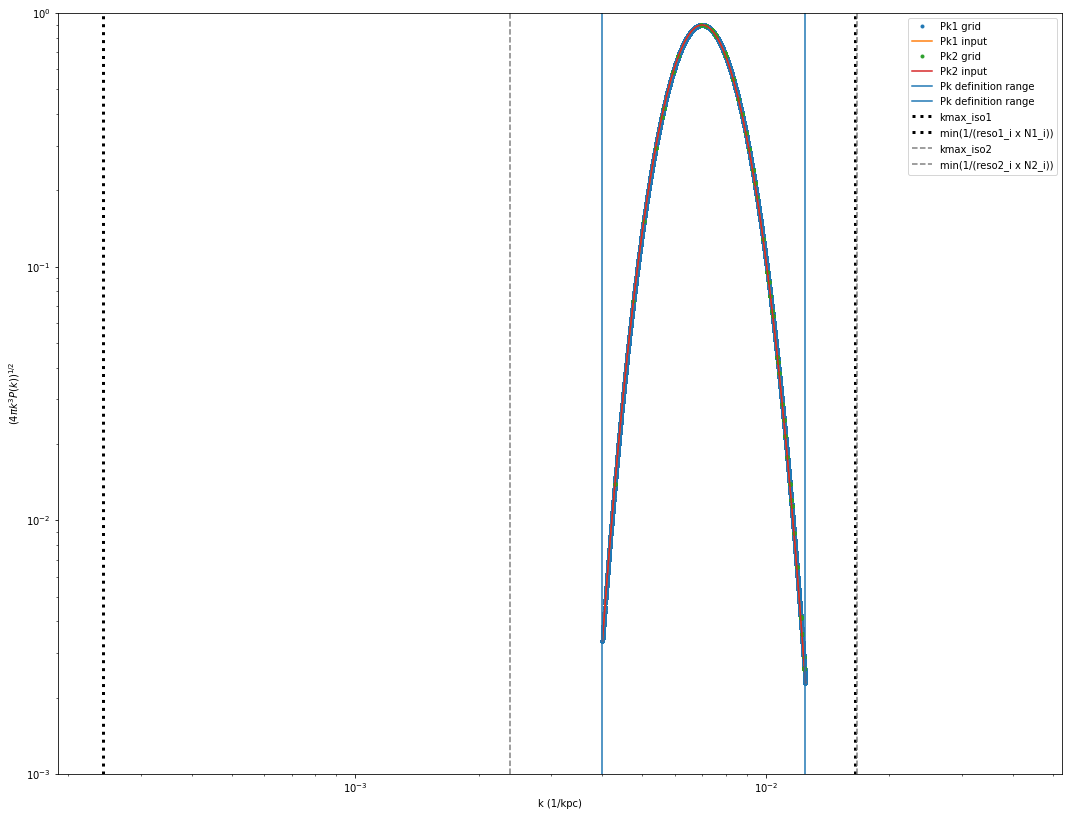

In [10]:
plt.figure(0, figsize=(18,14))

plt.loglog(k3d_grid1, np.sqrt(4*np.pi*k3d_grid1**3*P3d_k_grid1), marker='.', ls='', label='Pk1 grid')
plt.loglog(k1,np.sqrt(4*np.pi*k1**3*P3d_k1), label='Pk1 input')

plt.loglog(k3d_grid2, np.sqrt(4*np.pi*k3d_grid2**3*P3d_k_grid2), marker='.', ls='', label='Pk2 grid')
plt.loglog(k2,np.sqrt(4*np.pi*k2**3*P3d_k2), label='Pk2 input')

plt.axvline(1/(5*c1.model_pressure_fluctuation['Linj'].to_value('kpc')), label='Pk definition range')
plt.axvline(5/c1.model_pressure_fluctuation['Ldis'].to_value('kpc'), label='Pk definition range')

plt.axvline(kmax_isotropic(Nx1, Ny1, Nz1, proj_reso1, los_reso1), color='k', ls=':', lw=3, label='kmax_iso1')
plt.axvline(np.amin([1/(proj_reso1*Nx1), 1/(proj_reso1*Ny1), 1/(los_reso1*Nz1)]), color='k', ls=':', lw=3, label='min(1/(reso1_i x N1_i))')

plt.axvline(kmax_isotropic(Nx2, Ny2, Nz2, proj_reso2, los_reso2), color='grey', ls='--', label='kmax_iso2')
plt.axvline(np.amin([1/(proj_reso2*Nx2), 1/(proj_reso2*Ny2), 1/(los_reso2*Nz2)]), color='grey', ls='--', label='min(1/(reso2_i x N2_i))')

plt.ylim(1e-3, 1e0)
plt.xlabel('k (1/kpc)')
plt.ylabel(r'$(4 \pi k^3 P(k))^{1/2}$')
plt.legend()

# Check the rms distribution for many realization including in an extracted smaller patch

0.5000173567392187 0.4965884426408905 0.4980945667756449
(201, 201, 137) (21, 21, 14) (21, 21, 14)


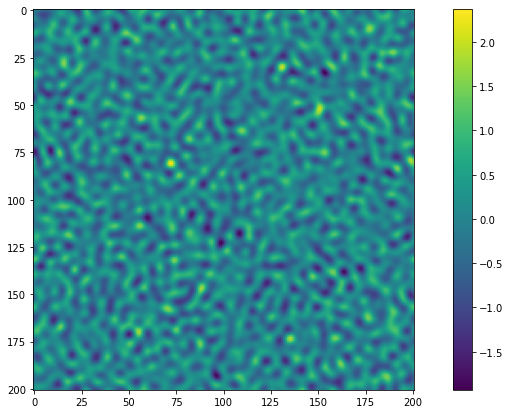

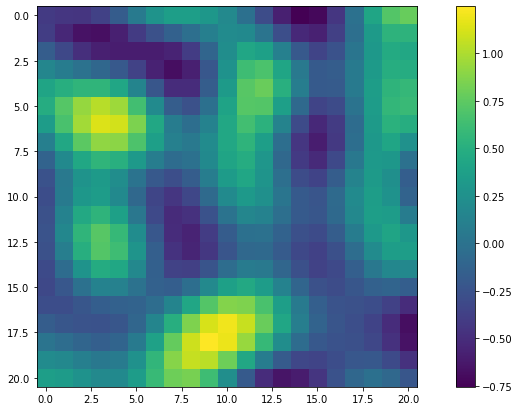

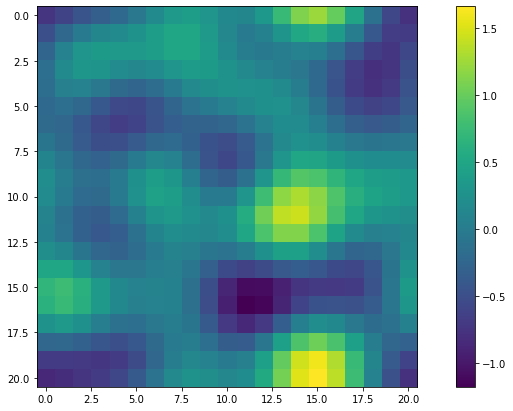

In [11]:
plt.figure(0, figsize=(14,7))
plt.imshow(cube1[:,:,np.int(cube1.shape[2]/2)])
plt.colorbar()

plt.figure(1, figsize=(14,7))
cube1_ext = cube1[0:cube2.shape[0],0:cube2.shape[1],0:cube2.shape[2]]
cube1_ext = cube1_ext - np.mean(cube1_ext)
plt.imshow(cube1_ext[:,:,np.int(cube1_ext.shape[2]/2)])
plt.colorbar()

plt.figure(3, figsize=(14,7))
plt.imshow(cube2[:,:,np.int(cube2.shape[2]/2)])
plt.colorbar()
print(np.std(cube1), np.std(cube1_ext), np.std(cube2))
print(cube1.shape, cube1_ext.shape, cube2.shape)

In [12]:
rms1 = []
rms1b = []
rms2 = []
for i in range(100):
    cube1, k3d_grid1, P3d_k_grid1 = gen_fluct(Nx1, Ny1, Nz1, 
                                          proj_reso1, los_reso1, 
                                          c1.model_pressure_fluctuation, silent=True)
    cube2, k3d_grid2, P3d_k_grid2 = gen_fluct(Nx2, Ny2, Nz2, 
                                              proj_reso2, los_reso2, 
                                              c2.model_pressure_fluctuation, silent=True)
    cube1_ext = cube1[0:cube2.shape[0],0:cube2.shape[1],0:cube2.shape[2]]
    
    rms1.append(np.std(cube1))
    rms1b.append(np.std(cube1_ext))
    rms2.append(np.std(cube2))

0.5001677492810079 0.5003062865390973 0.4870991263392221


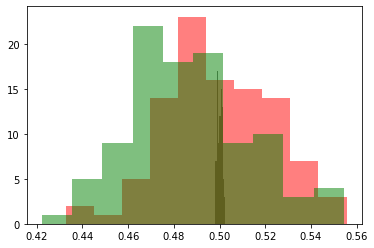

In [13]:
plt.hist(rms1,  color='k', alpha=0.5)
plt.hist(rms1b, color='r', alpha=0.5)
plt.hist(rms2,  color='g', alpha=0.5)
print(np.mean(rms1), np.mean(rms1b), np.mean(rms2))

# Measure the power spectrum and compare to input model

In [15]:
c = pitszi.Model(RA=150*u.deg, Dec=89*u.deg, redshift=0.5, M500=5e14*u.Msun, silent=False)
c.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                'Norm': 0.5,'slope': -11/3.,
                                'Linj': 1*u.Mpc,
                                'Ldis': 100*u.kpc}
c.map_fov   = 10*u.arcmin
c.map_reso  = 3*u.arcsec
c.los_reso  = 30*u.kpc
c.R_truncation = c.R500*2

scalebin = 'lin'
Nbin = 1000

Nx, Ny, Nz, proj_reso, proj_reso, los_reso = c.define_3dgrid()
k, P3d_k = define_p_k(Nx, Ny, Nz, proj_reso, los_reso, c.model_pressure_fluctuation)
cube, k3d_grid, P3d_k_grid = gen_fluct(Nx, Ny, Nz, 
                                       proj_reso, los_reso, 
                                       c.model_pressure_fluctuation, silent=True)
kout, pkout = measure_pk3d(cube, proj_reso, los_reso, scalebin=scalebin, Nbin=Nbin)
itpl = interp1d(k, P3d_k, kind='linear', fill_value=0, bounds_error=False)
P3d_k_itpl = itpl(kout)
    
Nsim = 100
pkout_store = np.zeros((Nsim, len(pkout)))               
for i in range(Nsim):
    cube, k3d_grid, P3d_k_grid = gen_fluct(Nx, Ny, Nz, 
                                       proj_reso, los_reso, 
                                       c.model_pressure_fluctuation, silent=True)
    kout, pkout = measure_pk3d(cube, proj_reso, los_reso, scalebin=scalebin, Nbin=Nbin)
    pkout_store[i,:] = pkout

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
Setting gNFW Planck coll. (2013) UPP.
Setting model_pressure_fluctuation value
Fixing: R500 if involved
Setting the map field of view
Setting: map_header to None, as map properties are now set by hand
Setting the map resolution value
Setting: map_header to None, as map properties are now set by hand
Setting the physical resolution value
Setting R_truncation value
Setting: theta_truncation ; Fixing: D_ang


(0.01, 0.5)

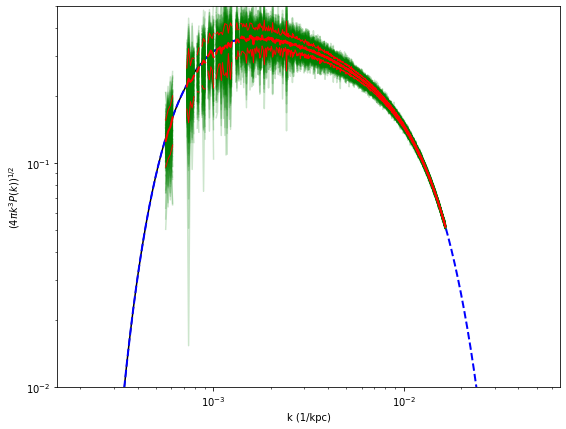

In [16]:
plt.figure(0, figsize=(9,7))
plt.loglog(kout, np.sqrt(4*np.pi*P3d_k_itpl*kout**3), color='k')
plt.loglog(k, np.sqrt(4*np.pi*P3d_k*k**3), color='blue', ls='--', lw=2)
for i in range(Nsim):
    plt.plot(kout, np.sqrt(4*np.pi*pkout_store[i,:]*kout**3), color='green', alpha=0.2)    
plt.plot(kout, np.mean(np.sqrt(4*np.pi*pkout_store*kout**3), axis=0), lw=2, color='r')
plt.plot(kout, np.mean(np.sqrt(4*np.pi*pkout_store*kout**3), axis=0)
         - np.std(np.sqrt(4*np.pi*pkout_store*kout**3), axis=0), lw=1, color='r')
plt.plot(kout, np.mean(np.sqrt(4*np.pi*pkout_store*kout**3), axis=0)
         + np.std(np.sqrt(4*np.pi*pkout_store*kout**3), axis=0), lw=1, color='r')
plt.xlabel('k (1/kpc)')
plt.ylabel(r'$(4 \pi k^3 P(k))^{1/2}$')
plt.ylim(1e-2,5e-1)

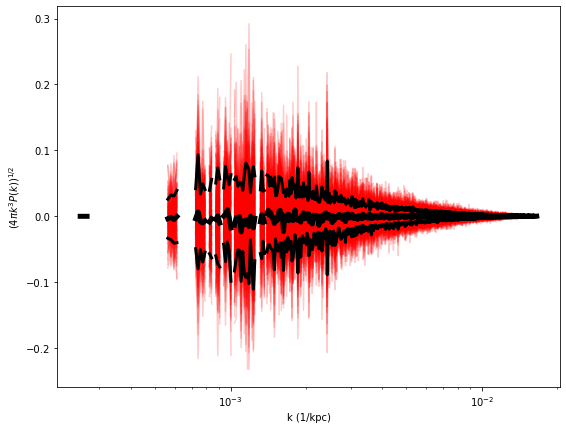

In [17]:
plt.figure(0, figsize=(9,7))
for i in range(Nsim):
    plt.plot(kout, np.sqrt(4*np.pi*pkout_store[i,:]*kout**3) - np.sqrt(4*np.pi*P3d_k_itpl*kout**3), color='red', alpha=0.2)
plt.plot(kout, np.mean(np.sqrt(4*np.pi*pkout_store*kout**3) - np.sqrt(4*np.pi*P3d_k_itpl*kout**3), axis=0), lw=5, color='k')
plt.plot(kout, np.mean(np.sqrt(4*np.pi*pkout_store*kout**3) - np.sqrt(4*np.pi*P3d_k_itpl*kout**3), axis=0)
         - np.std(np.sqrt(4*np.pi*pkout_store*kout**3) - np.sqrt(4*np.pi*P3d_k_itpl*kout**3), axis=0), lw=3, color='k')
plt.plot(kout, np.mean(np.sqrt(4*np.pi*pkout_store*kout**3) - np.sqrt(4*np.pi*P3d_k_itpl*kout**3), axis=0)
         + np.std(np.sqrt(4*np.pi*pkout_store*kout**3) - np.sqrt(4*np.pi*P3d_k_itpl*kout**3), axis=0), lw=3, color='k')
plt.xlabel('k (1/kpc)')
plt.ylabel(r'$(4 \pi k^3 P(k))^{1/2}$')
plt.xscale('log')